# Predictive Quality Control for Manufacturing

## Importing Required Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

## Data Preprocessing

In [3]:
def preprocess_data(file_path):
    # Load dataset
    data = pd.read_csv(file_path)

    # Check for non-numeric columns and attempt encoding
    for column in data.select_dtypes(include=['object']).columns:
        # If the column is categorical, encode it
        if data[column].dtype == 'object':
            # Option 1: Label encoding (if there are few unique values)
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])
    
    # Separate features (X) and target (y)
    X = data.drop(columns=['y1', 'y2'])  # Assuming 'y1' and 'y2' are the target columns
    y = data[['y1', 'y2']]  # Adjust this as needed
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the input data (features)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, data

## Exploratory Data Analysis (EDA)

In [4]:
def perform_eda(data):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.show()

    for col in ['u1', 'u2', 'u3', 'u4', 'u5']:
        try: 
            sns.scatterplot(x=data[col], y=data['y1'])
            plt.title(f'{col} vs Tension (T1)')
            plt.xlabel(col)
            plt.ylabel('Tension T1')
            plt.show()

            sns.scatterplot(x=data[col], y=data['y2'])
            plt.title(f'{col} vs Tension (T3)')
            plt.xlabel(col)
            plt.ylabel('Tension T3')
            plt.show()
        except:
            pass

## Predictive Modeling

In [5]:
def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    joblib.dump(model, 'tension_prediction_model.pkl')
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    return mse, r2, y_pred

## Quality Control Integration

In [6]:
def plot_spc_chart(y_test, threshold, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual T1', marker='o')
    plt.axhline(y_test.mean(), color='r', linestyle='dashed', label='Mean T1')
    plt.axhline(threshold, color='b', linestyle='solid', label='Upper Control Line')
    plt.axhline(-threshold, color='b', linestyle='solid', label='Lower Control Line')


    plt.xlabel('Sample Index')
    plt.ylabel('Tension')
    plt.legend()
    plt.title('Statistical Process Control Chart for ' + title)
    plt.show()

# Alarms

In [7]:
def trigger_alarm(y_pred, threshold=1.5):
    alarms = y_pred > threshold
    if np.any(alarms):
        print("Alarm triggered! Predicted values exceed the threshold.")
    else:
        print("No alarm. All predicted values are within the threshold.")

## Six Sigma Framework

In [8]:
def calculate_dpmk(y_actual, y_predicted, threshold=0.05):
    # Calculating Defects Per Million Opportunities (DPMO)
    defects_t1 = np.sum(np.abs(y_actual[:, 0] - y_predicted[:, 0]) > threshold)
    defects_t3 = np.sum(np.abs(y_actual[:, 1] - y_predicted[:, 1]) > threshold)
    
    opportunities = len(y_actual) * 2  # T1 and T3
    defects = defects_t1 + defects_t3
    
    return (defects / opportunities) * 1_000_000

def calculate_cpk(data, usl, lsl):
    # Calculating Process Capability Index (Cpk)
    mean = data.mean()
    std_dev = data.std()
    cpu = (usl - mean) / (3 * std_dev)
    cpl = (mean - lsl) / (3 * std_dev)
    
    return min(cpu, cpl)

In [9]:

def findOutliers(dataframe, threshold, key) -> pd.DataFrame:
    if key not in dataframe.columns:
        raise ValueError("The DataFrame does not contain a 'y1' column.")

    outliers = dataframe[(dataframe[key] > threshold)] #| (dataframe[key] < -1*threshold) Only positive for testing
    
    return outliers

## Running the Workflow

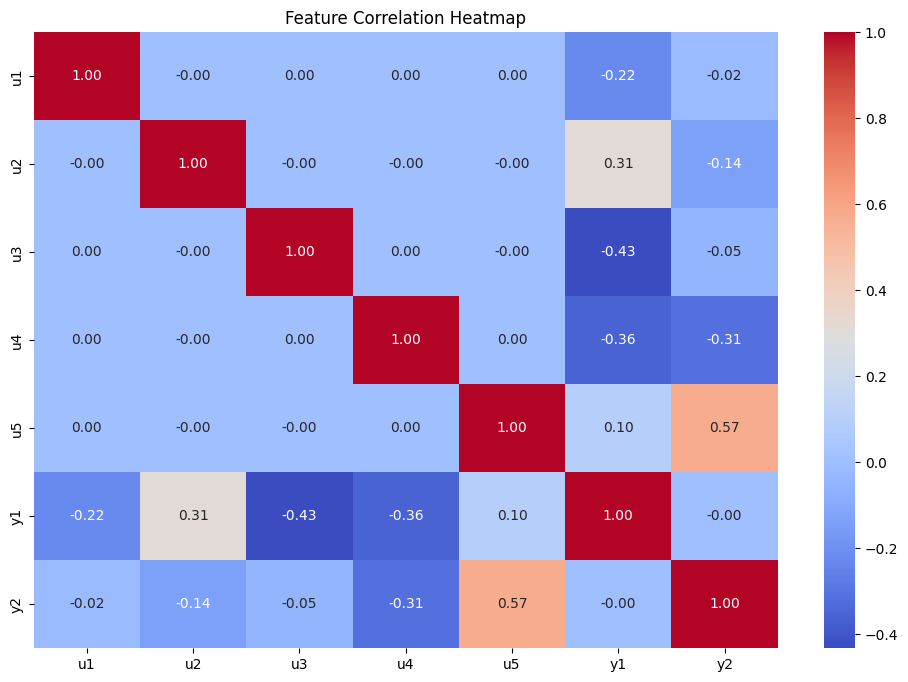

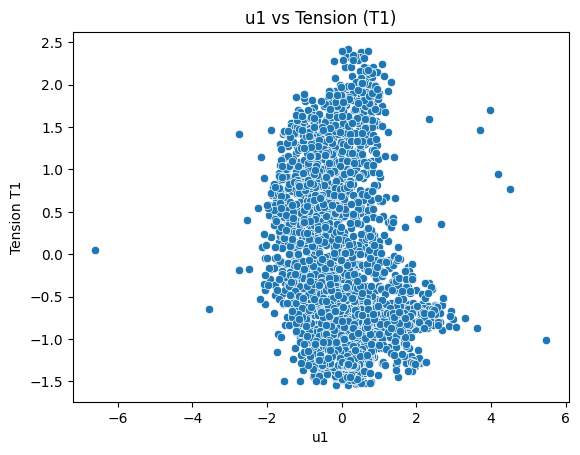

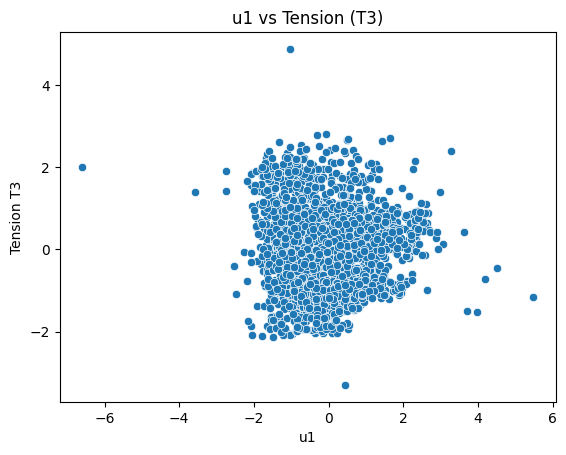

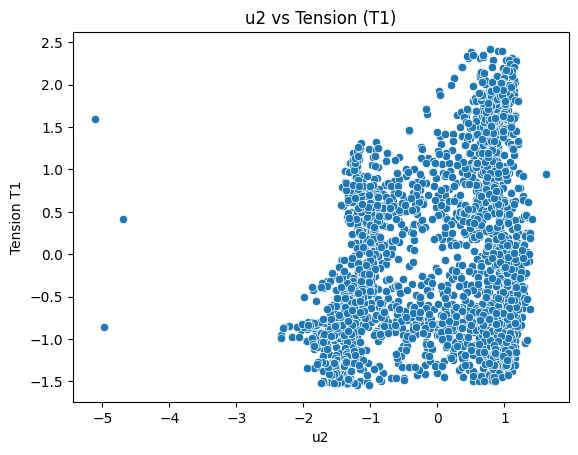

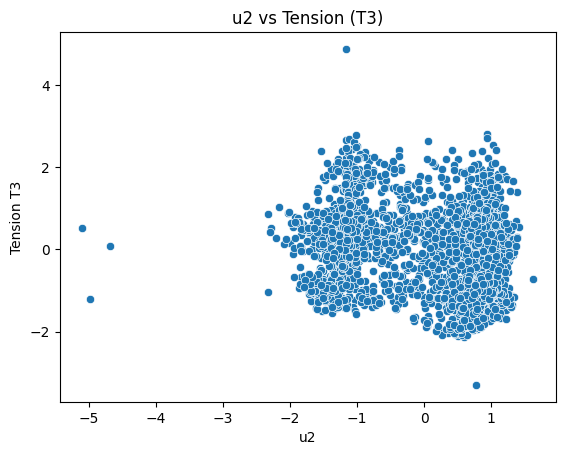

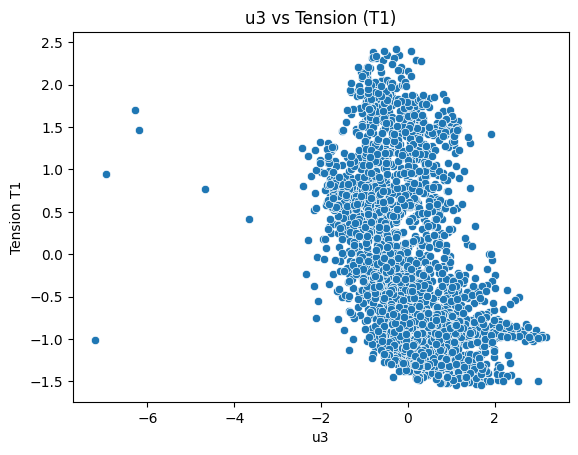

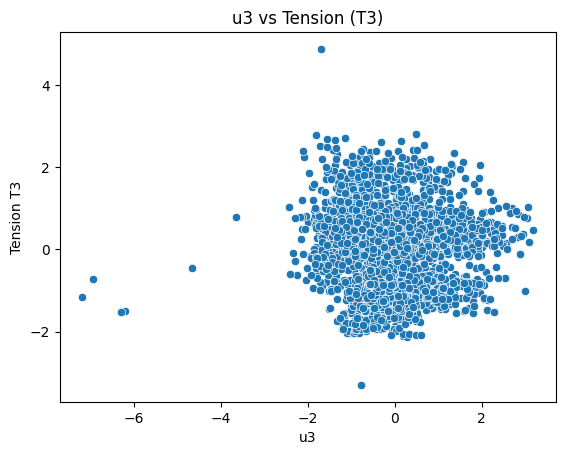

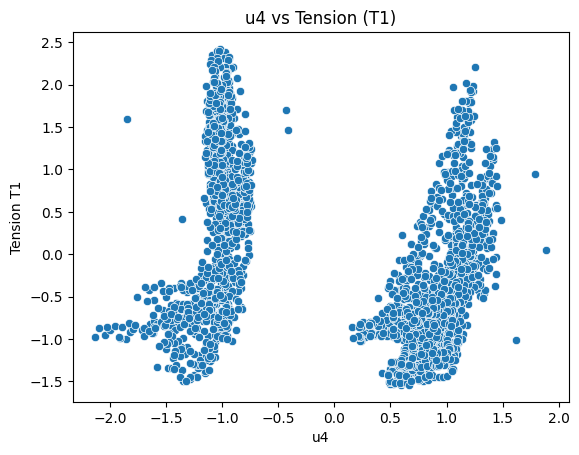

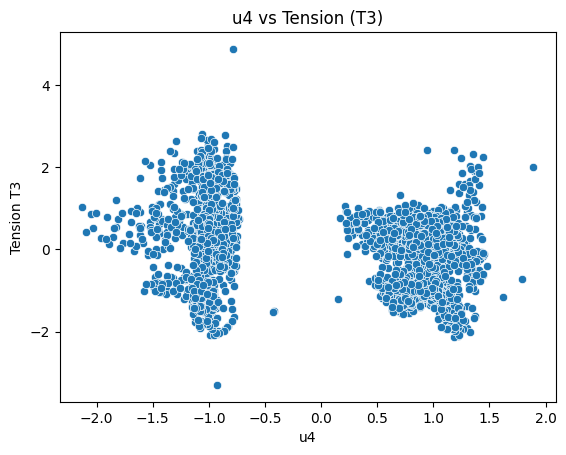

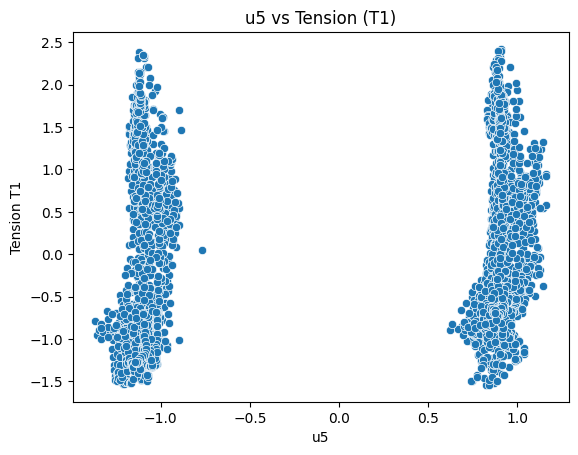

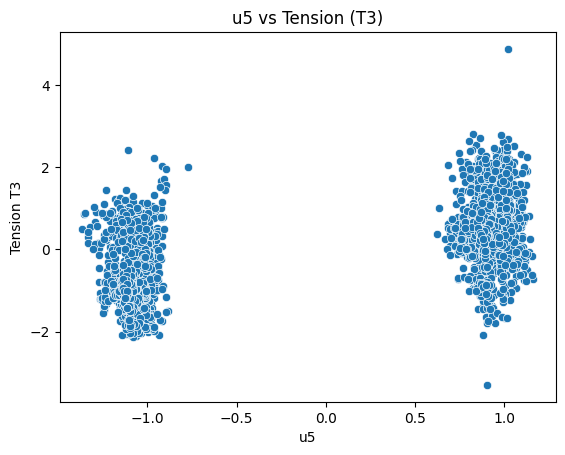

Model Performance: MSE = 0.4890, R² Score = 0.4799
Threshold = 1.491755509241037


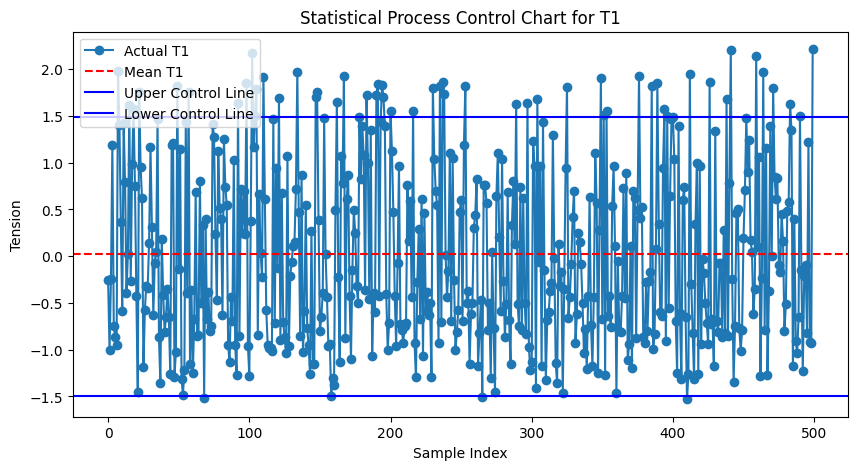

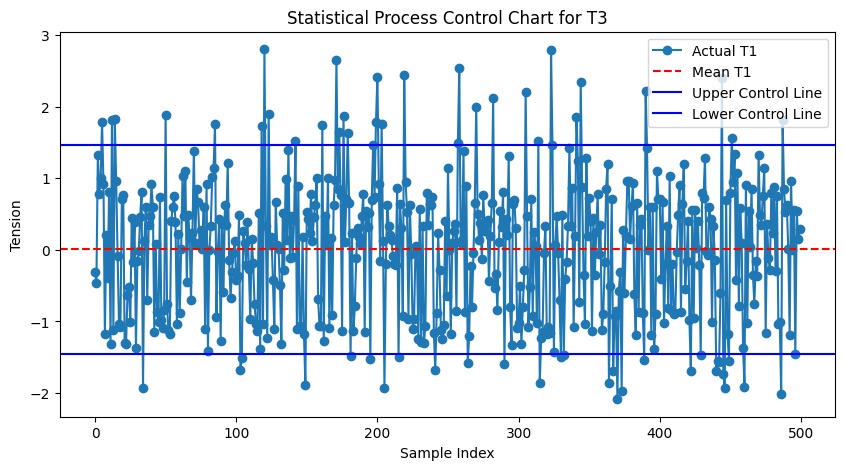

Alarm triggered! Predicted values exceed the threshold.


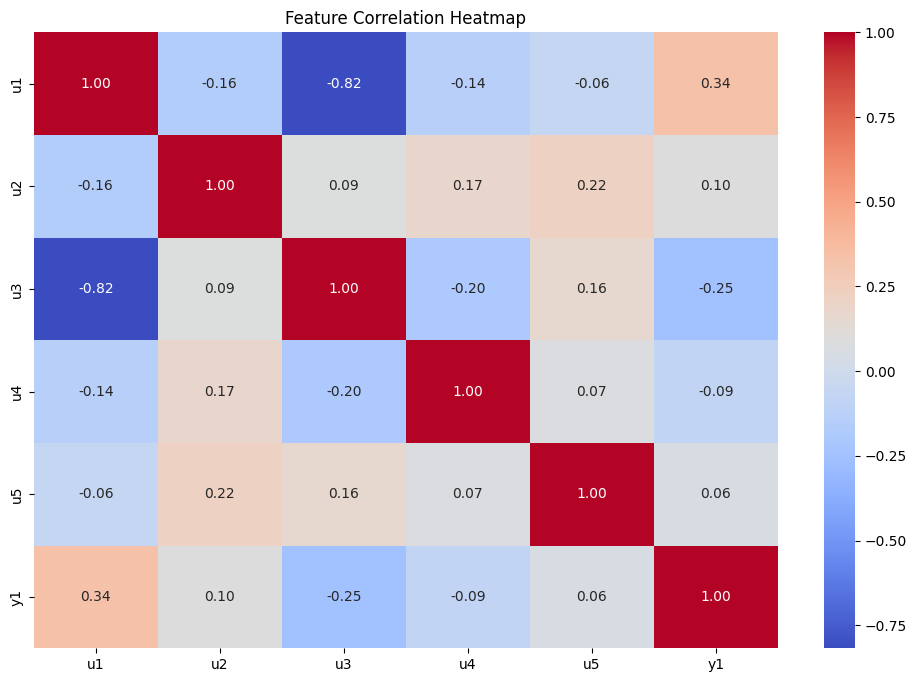

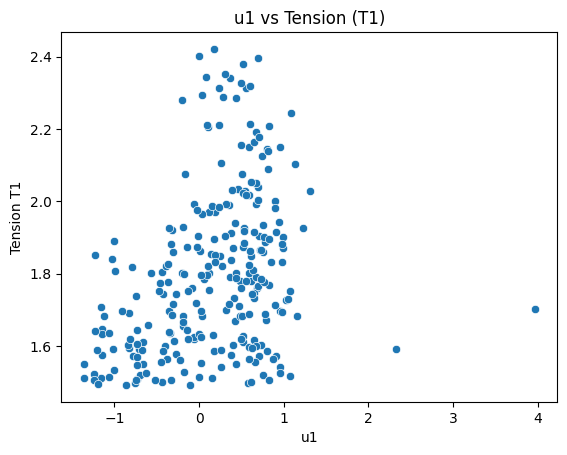

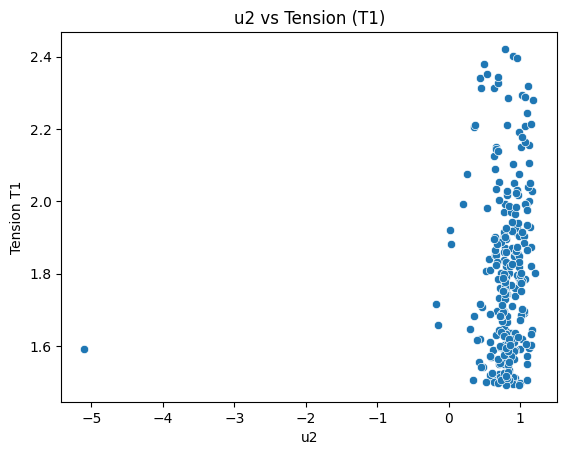

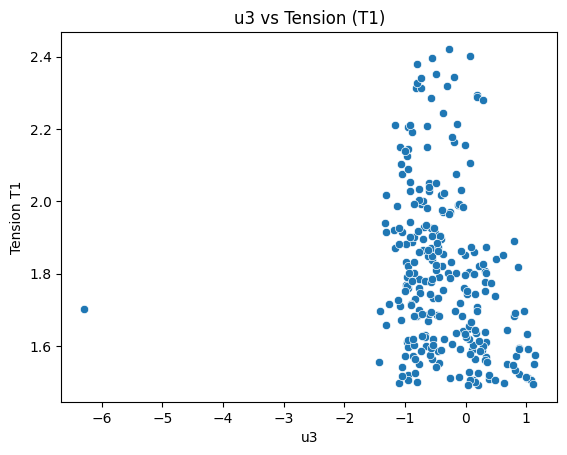

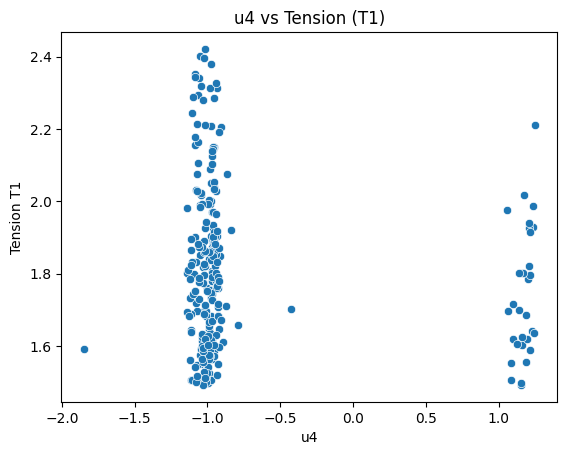

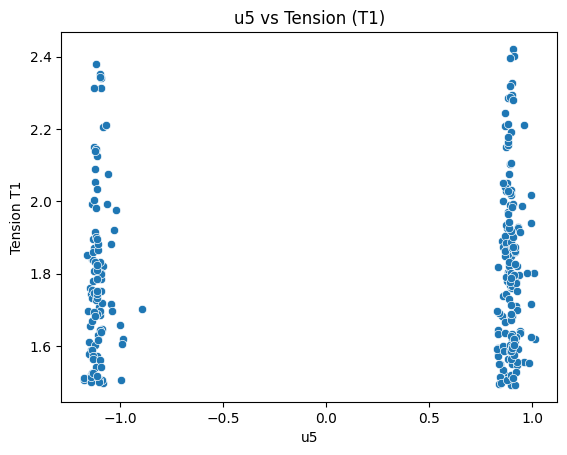

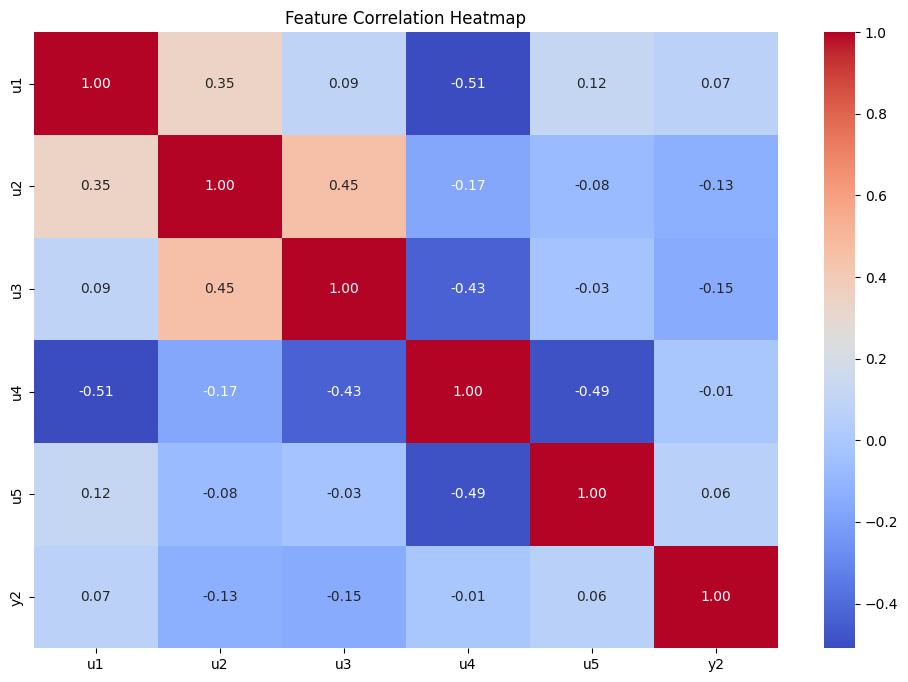

Defects Per Million Opportunities (DPMO): 918000.00
Process Capability Index (Cpk): 0.01


In [10]:
# Load and preprocess the dataset
file_path = 'processData.csv'  # Update this with the actual dataset path
X_train, X_test, y_train, y_test, data = preprocess_data(file_path)

# Perform EDA
perform_eda(data)

# Train the predictive model
model = train_model(X_train, y_train)

# Evaluate the model
mse, r2, y_pred = evaluate_model(model, X_test, y_test)
print(f'Model Performance: MSE = {mse:.4f}, R² Score = {r2:.4f}')

#Threshold
thresholdy1 = y_test['y1'].mean() + 1.5*y_test['y1'].std()
print("Threshold = " + str(thresholdy1))
thresholdy2 = y_test['y2'].mean() + 1.5*y_test['y2'].std() 

# Quality Control Integration
plot_spc_chart(y_test['y1'], thresholdy1, 'T1')
plot_spc_chart(y_test['y2'], thresholdy2, 'T3')

trigger_alarm(y_pred, threshold=thresholdy1)  # Set the threshold for alarms

#Gather Outliers
outliersy1 = findOutliers(data, thresholdy1, 'y1')
outliersy1 = outliersy1.drop(columns='y2', axis=1)
outliersy2 = findOutliers(data, thresholdy2, 'y2')
outliersy2 = outliersy2.drop(columns='y1',axis=1)


#plot outliers
perform_eda(outliersy1)
perform_eda(outliersy2)




# Six Sigma Analysis
dpmk = calculate_dpmk(y_test.values, y_pred, threshold=0.05)
cpk = calculate_cpk(y_test.values, usl=2.0, lsl=0.0)  # Example upper and lower spec limits
print(f'Defects Per Million Opportunities (DPMO): {dpmk:.2f}')
print(f'Process Capability Index (Cpk): {cpk:.2f}')